In [1]:
import torch
import scanpy as sc
import celldiffusion as cd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_trajectory_benchmark_datasets/Planaria-full_plass/'

OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'planaria-full_plass.h5ad')
adata

AnnData object with n_obs × n_vars = 18837 × 4210
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'
    uns: 'benchmark_traj'

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


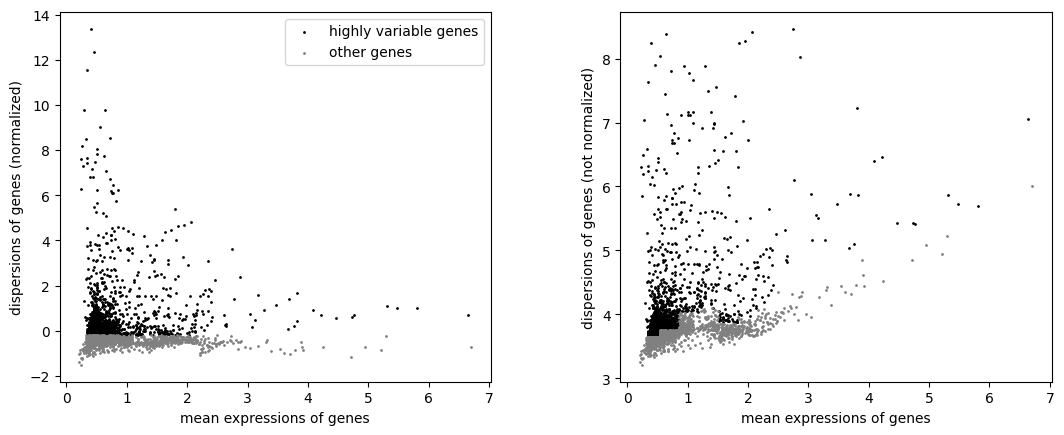

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata


View of AnnData object with n_obs × n_vars = 18837 × 2000
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'benchmark_traj', 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [7]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                   D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-07-21 15:19:36,346 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-07-21 15:19:38,147 - ------------------------> Epoch: 1/2000, Current loss: 19200376.0000
2025-07-21 15:19:39,583 - ------------------------> Epoch: 51/2000, Current loss: 11496547.0000
2025-07-21 15:19:41,019 - ------------------------> Epoch: 101/2000, Current loss: 10720466.0000
2025-07-21 15:19:42,453 - ------------------------> Epoch: 151/2000, Current loss: 10318692.0000
2025-07-21 15:19:43,883 - ------------------------> Epoch: 201/2000, Current loss: 10109876.0000
2025-07-21 15:19:45,318 - ------------------------> Epoch: 251/2000, Current loss: 100141

## Check isolated nodes (Not necessary)

In [8]:
cd.util.evaluate_node_isolation(adata, use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                predict_pct=0.15)  # Isolated nodes ratio.

The isolation inofrmation can be used to prune edges for single cell graph.

# Diffusion

In [9]:
# This graph provides the adjacency that will be used in loss function.
cd.graph.build_adj_graph(adata, 
                         use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                         k=50,            # K for building a KNN graph.
                         device=device)

In [10]:
# This graph is used in the graph neural diffusion process.
cd.graph.build_diffusion_graph(adata, 
                               use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                               k=50,            # K for building a KNN graph.
                               prune=False,     # If True, prune graph edges for isolated nodes.
                               device=device)

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [11]:
cd.graph_diffusion(adata, 
                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                   max_epoch=2000,  # number of epoch
                   lr=1e-3,         # number of learning rate
                   time_increment_diffusion=0.2,  # Suggest value >0.0 & <=0.5. Larger value indicates stronger feature diffusion.
                   loss_adj=0.0,      # value 0 will recover the input data; value 1 will recover input KNN adjacency.
                   edge_rewire=False, # If True, rebuild KNN graph in each diffusion layer. Set as False to keep more inter-cluster relationships for trajectory inference and accelerate the training process.
                   device=device)


2025-07-21 15:20:36,086 - --------> Starting graph nueral diffusion ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/graph_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adjacency, dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/graph_DIF.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(target_features, dtype = out_nodes_features.dtype)
2025-07-21 15:20:36,888 - ------------------------> Epoch: 1/2000, Current loss: 31049264.0000
2025-07-21 15:20:48,589 - ------------------------> Epoch: 51/2000, Current loss: 11682998.0000
2025-07-21 15:21:00,304 - ------------------------> Epoch: 101

## View UMAP of diffused embeddings

In [12]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


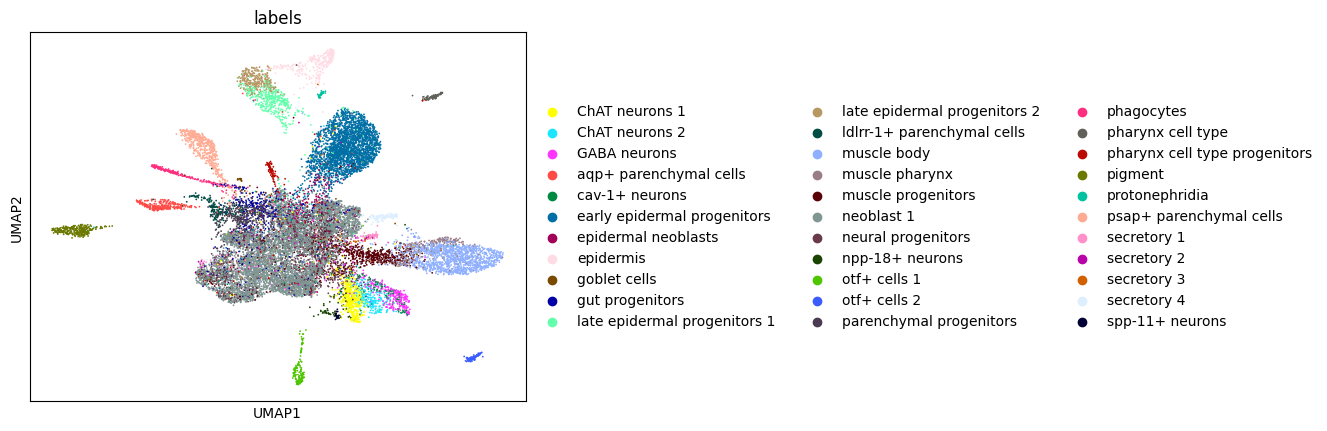

In [13]:
sc.pl.umap(adata, color=['labels'])

# Trajectory

In [14]:
cd.graph.build_graph(adata, use_rep="X_dif", k=50, device=device) # build KNN graph for clustering

In [15]:
cd.graph.call_attention(adata, device=device)  # generate cell-cell attention network

In [16]:
cd.anal.build_trajectory(adata, 
                     use_groups = 'labels',       # cell labels used to infer trajectory
                     origin_group = 'neoblast 1', # set the root cell label of trajectory
                     use_community=None,          # If None, use cell labels to build cell community.
                     use_rep = 'X_dif',           # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                     use_weights = 'attention',   # Using cell-cell attention information.
                     traj_shape='mdo_tree',       # Choose build-in tree shape trajectory inference method.
                     device=device,
                     save_csv = None)     # save trajectory into CSV file.

/projectnb/czproj/Algorithms/ycliu/Pan_proj/sc_analysis/trajectory.py:131: RuntimeWarning: divide by zero encountered in divide
  attention_matrix = 1/(numpy.log(aaa + 1))


## Show trajectory in an edge list [(from, to, attention weight),]

In [17]:
adata.uns['trajectory']

[('neoblast 1', 'epidermal neoblasts', np.float32(0.8020838)),
 ('neoblast 1', 'gut progenitors', np.float32(0.96752876)),
 ('neoblast 1', 'neural progenitors', np.float32(1.0124779)),
 ('neoblast 1', 'pharynx cell type progenitors', np.float32(1.0699701)),
 ('neoblast 1', 'parenchymal progenitors', np.float32(1.163997)),
 ('gut progenitors', 'goblet cells', np.float32(0.3939877)),
 ('neoblast 1', 'secretory 1', np.float32(1.5366727)),
 ('parenchymal progenitors',
  'ldlrr-1+ parenchymal cells',
  np.float32(0.41207573)),
 ('gut progenitors', 'phagocytes', np.float32(0.6266943)),
 ('pharynx cell type progenitors',
  'pharynx cell type',
  np.float32(0.55154115)),
 ('neoblast 1', 'muscle progenitors', np.float32(1.6645296)),
 ('neoblast 1', 'secretory 3', np.float32(1.703548)),
 ('neoblast 1', 'secretory 4', np.float32(1.7202487)),
 ('neural progenitors', 'cav-1+ neurons', np.float32(0.7444698)),
 ('neural progenitors', 'npp-18+ neurons', np.float32(0.77768505)),
 ('neural progenitors',

## Trajectory visualization

In [18]:
# Use points to represent cell types in UMAP plot.
cd.anal.community_umap(adata, use_umap = 'X_umap')

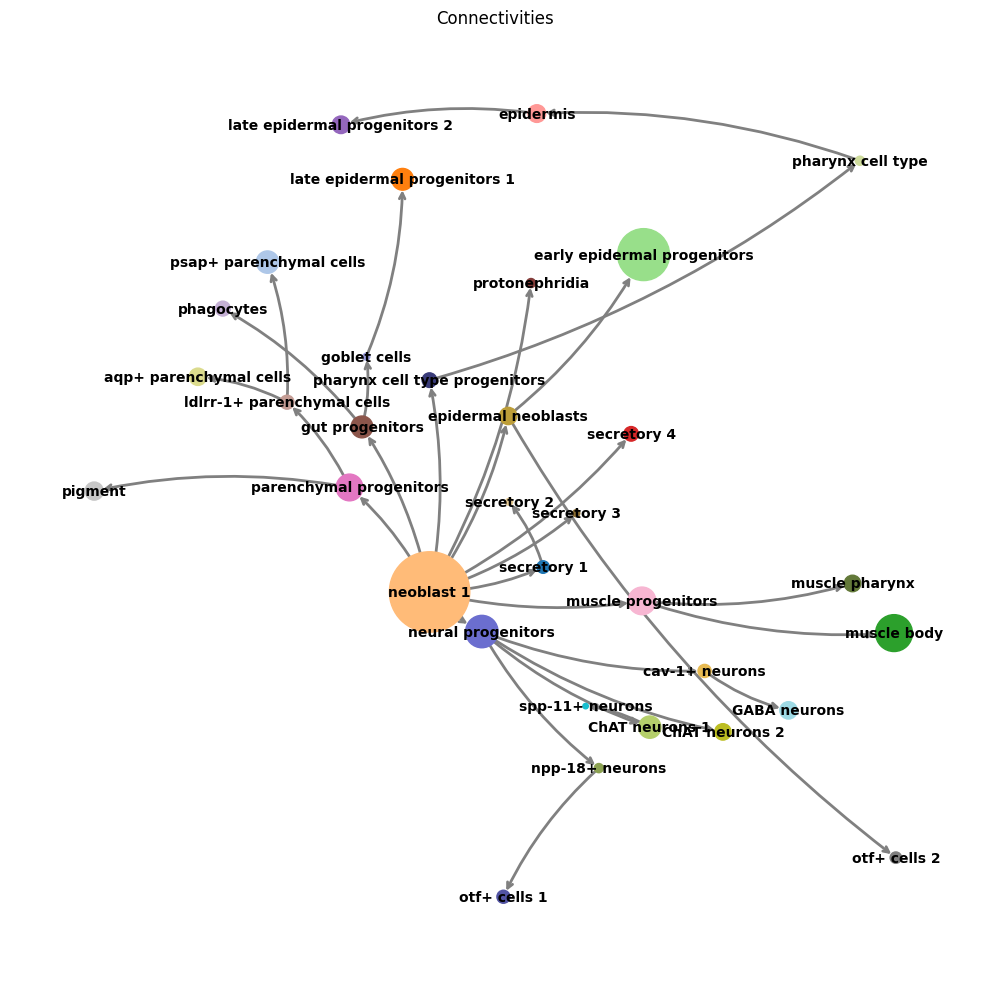

In [19]:
cd.anal.plot_trajectory(adata, 
                        node_scale = 10000, 
                        node_color = None,
                        edge_width=2, 
                        edge_color='gray', 
                        figsize=(10, 10), 
                        font_size=10, 
                        font_weight='bold',
                        title='Connectivities',
                        save_fig=None)

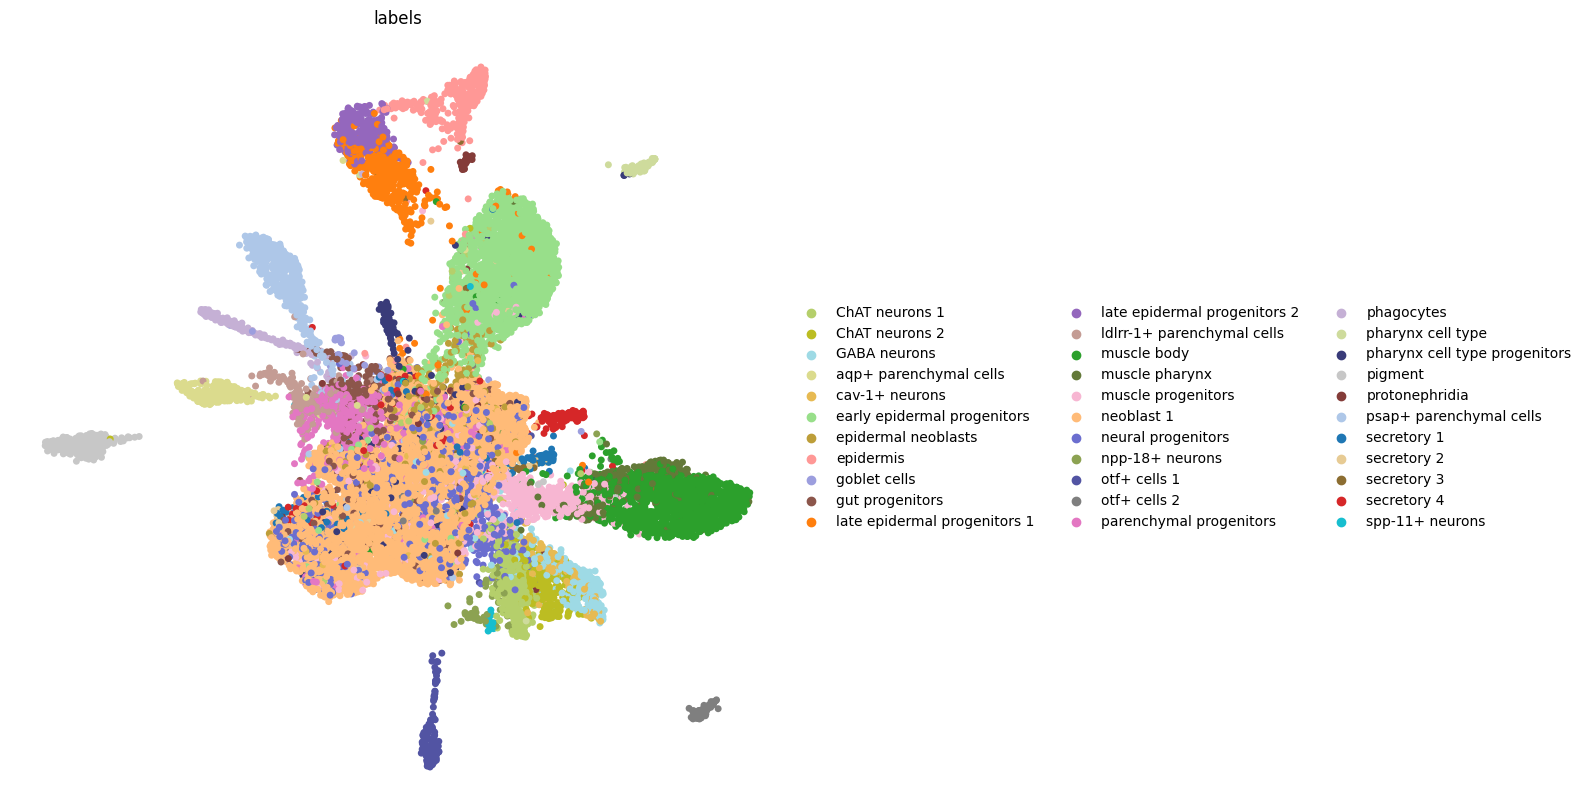

In [20]:
# Plot UMAP with the same color_map for cell types as the trajectory plot

import numpy as np
from matplotlib import rcParams

FIGSIZE = (10, 10)
rcParams["figure.figsize"] = FIGSIZE

unique_values = np.array(adata.uns['community']['keys'])
colors = cd.util.unique_colors(unique_values)
palette = {cell_type: color for cell_type, color in zip(unique_values, colors)}

sc.pl.umap(adata, color=['labels'], palette = palette, frameon=False, 
           legend_fontsize = 10,
           size=100)


# Save data

In [21]:
adata.write(OUTPUT_PATH+'scDiffusion_adata.h5ad')

In [22]:
adata = sc.read_h5ad(OUTPUT_PATH+'scDiffusion_adata.h5ad')